### Napari tests

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style='white')
%config InlineBackend.figure_format = 'retina'

In [2]:
import napari

In [3]:
viewer = napari.Viewer()

In [7]:
current_indices = viewer.dims.current_step
current_indices

(1752, 971, 971)

(10, 971, 971)


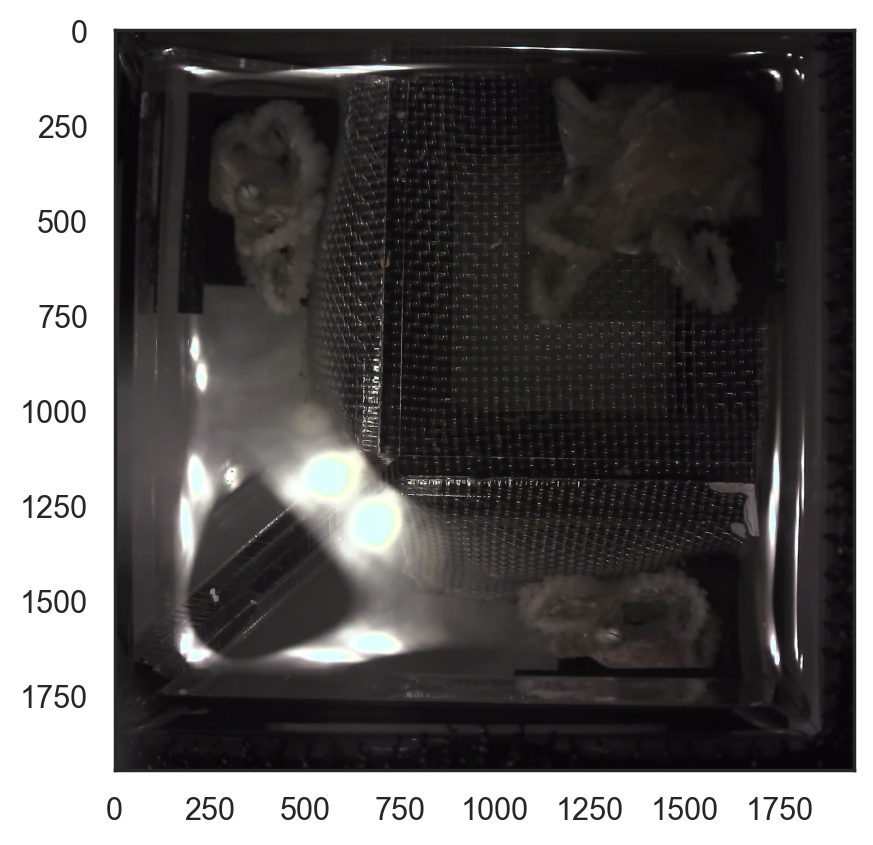

(11, 971, 971)


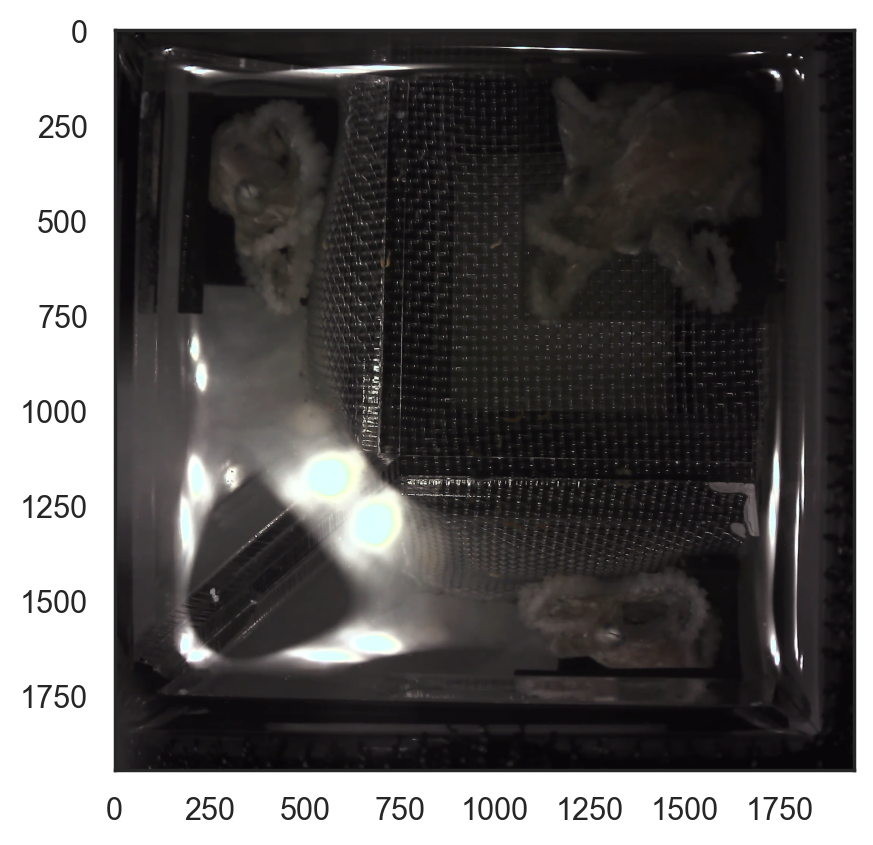

In [10]:
viewer.dims.set_point(0,10)
current_indices = viewer.dims.current_step
print(current_indices)
image_data1 = viewer.layers[0].data[current_indices[0],:,:,:]
image_data1.shape
plt.imshow(image_data1)
plt.show() 
# Set to different index 
viewer.dims.set_point(0,11)
current_indices = viewer.dims.current_step
print(current_indices)
current_indices = viewer.dims.current_step
image_data2 = viewer.layers[0].data[current_indices[0],:,:,:]
image_data2.shape
plt.imshow(image_data2)


In [11]:
(image_data1 == image_data2).all()

np.False_